In [1]:
import numpy as np
import cupy as cp
cp.set_printoptions(precision=2)
np.set_printoptions(precision=2)
import idx2numpy
import matplotlib.pyplot as plt

print(cp.cuda.runtime.getDeviceCount())
x = cp.array([1, 2, 3])
print(x.device)

1
<CUDA Device 0>


In [2]:
# load training images and labels
train_data=idx2numpy.convert_from_file('MNIST/train-images-idx3-ubyte')
train_data = np.reshape(train_data,(60000,28*28))
train_label = idx2numpy.convert_from_file('MNIST/train-labels-idx1-ubyte')
train_label = cp.array(train_label)

# load testing images and labels
test_data=idx2numpy.convert_from_file('MNIST/t10k-images-idx3-ubyte')
test_data = np.reshape(test_data,(10000,28*28))
test_label = idx2numpy.convert_from_file('MNIST/t10k-labels-idx1-ubyte')
test_label = cp.array(test_label)

num_classes = 10
Feature_size = train_data.shape[1]

# some reshaping and normalizing, moving to gpu
X = cp.array(train_data,dtype=float).T / 255
X_normer = cp.sqrt(cp.sum(X*X, axis=1))
X = cp.transpose (X.T / X_normer)
X[cp.isnan(X)] = 0
Y = cp.zeros((num_classes, X.shape[1])) #one hot encode
Y[train_label, cp.arange(X.shape[1])] = 1

X_test = cp.array(test_data,dtype=float).T / 255
X_test = cp.transpose (X_test.T / X_normer)
X_test[cp.isnan(X_test)] = 0
Y_test = cp.zeros((num_classes, X_test.shape[1])) #one hot encode
Y_test[test_label, cp.arange(X_test.shape[1])] = 1

In [4]:
def accuracy(pred_class, true_class):
    pred = pred_class.argmax(axis=0)
    accuracy = (pred == true_class).sum()/true_class.shape[0]
    return accuracy

In [5]:
#pretty straight forward whats happening here
epochs = 200
lr=1
W = cp.random.normal(size=(num_classes,Feature_size))

logprobs = []
grad_norms = []
lrs = []
for i in range(epochs):
    Y_pred = W @ X
    
    exp_pred = cp.exp(Y_pred)
    summed = exp_pred.sum(axis=0)
    softmax_pred = exp_pred/summed
    
    gradient = (Y-softmax_pred) @ X.T
    
    W = W + lr*gradient
    lr = lr*0.99
    

    log_prob = (Y*Y_pred).sum() - cp.log(summed).sum()
    logprobs.append(log_prob.item())
    grad_norms.append(cp.linalg.norm(gradient).item())
    lrs.append(lr)


    
    if i%10==0:  
        print(i, ", log_prob:", log_prob, "train accurcy: ",accuracy(Y_pred, train_label) ,"test accurcy:", accuracy(W@X_test, test_label))

0 , log_prob: -138325.44628187874 train accurcy:  0.13643333333333332 test accurcy: 0.6399
10 , log_prob: -55204.663584586 train accurcy:  0.8107166666666666 test accurcy: 0.8303
20 , log_prob: -28557.63727417949 train accurcy:  0.88665 test accurcy: 0.893
30 , log_prob: -22454.096609837376 train accurcy:  0.9029833333333334 test accurcy: 0.9048
40 , log_prob: -20192.863426299766 train accurcy:  0.9100666666666667 test accurcy: 0.9098
50 , log_prob: -18919.425749512855 train accurcy:  0.91475 test accurcy: 0.9145
60 , log_prob: -18170.235356465448 train accurcy:  0.9172166666666667 test accurcy: 0.9172
70 , log_prob: -17677.25162956782 train accurcy:  0.9194166666666667 test accurcy: 0.9184
80 , log_prob: -17330.894023812958 train accurcy:  0.9203666666666667 test accurcy: 0.9202
90 , log_prob: -17076.290887436946 train accurcy:  0.9213333333333333 test accurcy: 0.9216
100 , log_prob: -16882.536335869343 train accurcy:  0.9221833333333334 test accurcy: 0.922
110 , log_prob: -16731.0094

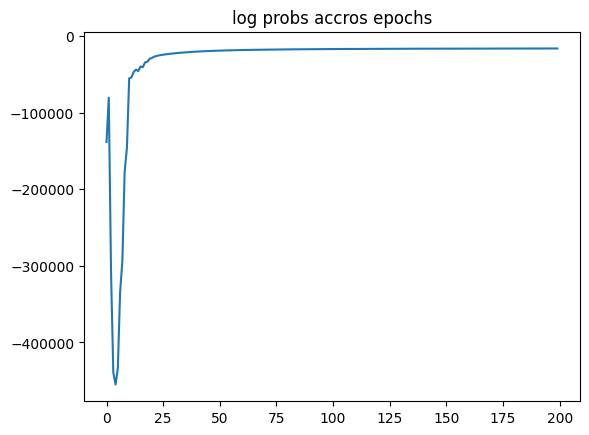

In [6]:
plt.title("log probs accros epochs")
plt.plot(logprobs)
plt.show()

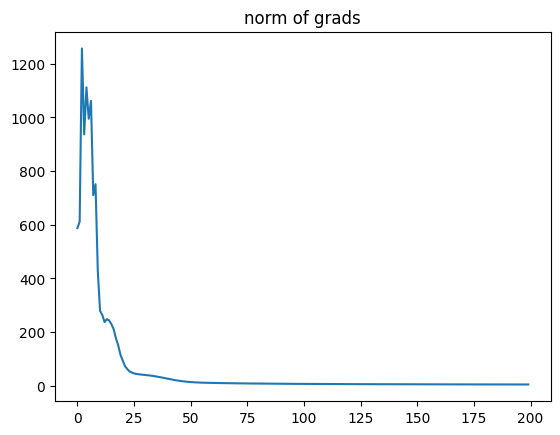

In [7]:
plt.title("norm of grads")
plt.plot(grad_norms)
plt.show()

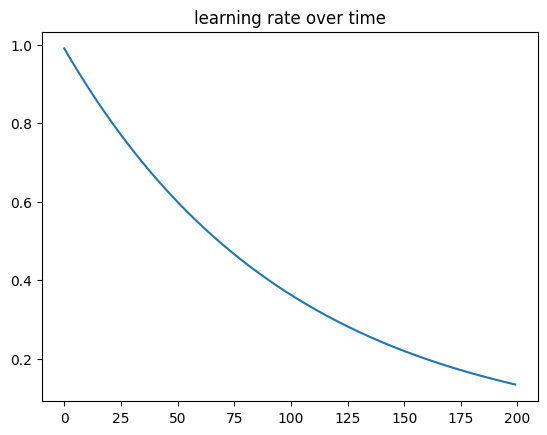

In [8]:
plt.title("learning rate over time")
plt.plot(lrs)
plt.show()